In [25]:
import numpy as np
import pandas as pd
import sklearn as skl
from quant_tools import portfolio_optimization as opt, performance_analysis as pt, data_preprocessing as dp
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

Make ATR & Co-ATR Functions

In [2]:
from pandas_ta.overlap import ma

def true_range(prices):
    """Function to get the var_atr & cov_atr which allows traders to leverage atr in a similar manner to variance & covariance.

    Args:
        prices (_type_): _description_
    """

    high = prices.High
    low = prices.Low
    close = prices["Adj Close"]

    ranges = [high - low, high - close.shift(1), close.shift(1) - low]
    true_range = pd.concat(ranges, axis=1)
    true_range = true_range.abs().max(axis=1)
    
    return true_range

def true_range_covariance(true_ranges: pd.DataFrame, lookback_window=20, ma_type='sma'):
    """Function to get the var_atr & cov_atr which allows traders to leverage atr in a similar manner to variance & covariance.

    Args:
        prices (_type_): _description_
    """
    sample_true_ranges = true_ranges.tail(lookback_window)
    n = lookback_window
    cov_true_range = sample_true_ranges.T.dot(sample_true_ranges) / (n-1)
    
    return cov_true_range

In [3]:
tickers = pd.read_csv(r'C:\Users\marcu\Documents\Quant\Programming\Data\sp500-master\sp500.csv').iloc[:, 0].head(100).values
tickers

array(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP',
       'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE',
       'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN',
       'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK',
       'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA',
       'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO',
       'ADSK', 'AZO', 'AVB', 'AVY', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX',
       'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK',
       'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO',
       'BF.B', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX',
       'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC',
       'CNP', 'CDAY'], dtype=object)

In [4]:
# Close Prices
close_asset_prices = pd.DataFrame()

# Returns of opening prices
open_asset_returns = pd.DataFrame()

# Returns of close prices
close_asset_returns = pd.DataFrame()

# True Ranges of Prices
true_ranges = pd.DataFrame()

# tickers = ['GLD', 'SPY', 'AAPL', 'BIL']

for ticker in tickers:

    prices = yf.download(ticker, start='2020-01-01', end=dt.date.today())
    
    # Get i'th asset's returns
    close_prices = prices['Adj Close'].dropna()
    close_prices = close_prices.rename(ticker)
    close_rets = prices['Adj Close'].pct_change().dropna()
    close_rets = close_rets.rename(ticker)
    open_rets = prices['Open'].pct_change().dropna()
    open_rets = open_rets.rename(ticker)
    tmp_true_range = true_range(prices) # ta.atr(high=prices['High'], low=prices['Low'], close=prices['Adj Close'], length=20)
    tmp_true_range = tmp_true_range.rename(ticker)

    close_asset_prices = pd.concat([close_asset_prices, close_prices, ], axis=1)
    close_asset_returns = pd.concat([close_asset_returns, close_rets], axis=1)
    open_asset_returns = pd.concat([open_asset_returns, open_rets], axis=1)
    true_ranges = pd.concat([true_ranges, tmp_true_range], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
close_asset_prices.drop(columns=['BRK.B', 'BF.B'], inplace=True)
true_ranges.drop(columns=['BRK.B', 'BF.B'], inplace=True)

In [6]:
dp.true_range_covariance(true_ranges)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY
MMM,3.702838,2.657204,3.534087,4.808625,8.990897,2.665774,3.194025,13.704202,7.596449,5.873295,...,2.652774,6.994644,10.718221,4.036382,2.880063,7.565534,5.408521,3.164656,0.878942,4.156943
AOS,2.657204,2.289340,2.958357,3.693886,6.566971,1.656541,2.133692,10.127007,5.510243,4.367921,...,2.135372,5.157963,8.542658,3.061317,2.267430,6.652206,3.983966,2.348392,0.720589,3.093860
ABT,3.534087,2.958357,7.042799,5.793151,9.100657,2.297877,3.095910,15.563517,7.447721,6.376909,...,2.785172,6.419167,10.829554,4.918160,3.104801,19.180307,5.681683,3.841149,1.026629,4.417339
ABBV,4.808625,3.693886,5.793151,7.537565,12.390170,4.194094,4.043337,20.179320,11.242518,8.209443,...,3.832205,9.171842,14.456018,5.737345,4.079653,12.643441,7.288493,4.560235,1.384806,5.964806
ACN,8.990897,6.566971,9.100657,12.390170,24.964064,5.346275,7.656027,35.437493,18.199250,14.782171,...,6.553978,19.672115,26.317929,10.441146,7.232240,19.348176,13.684282,7.988213,2.421122,11.136933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CDW,7.565534,6.652206,19.180307,12.643441,19.348176,3.954172,7.086082,33.811147,14.529078,13.837442,...,5.829543,16.866107,23.424957,11.858497,6.894520,58.393809,12.540553,9.086554,2.095175,9.030628
CE,5.408521,3.983966,5.681683,7.288493,13.684282,3.260102,4.893256,20.735559,10.965858,8.744044,...,3.792014,10.265443,15.732550,6.073685,4.327062,12.540553,8.668059,4.836859,1.340489,6.539372
CNC,3.164656,2.348392,3.841149,4.560235,7.988213,2.841681,2.963460,13.042095,7.022427,5.176025,...,2.555650,6.510995,8.829987,3.787476,2.556014,9.086554,4.836859,3.370416,0.878305,3.805412
CNP,0.878942,0.720589,1.026629,1.384806,2.421122,0.730179,0.702542,3.841346,2.084815,1.517231,...,0.730461,1.866996,2.677257,1.108505,0.771631,2.095175,1.340489,0.878305,0.291752,1.133537


Create atr risk parity optimization functions

In [7]:
from scipy.optimize import minimize as minimize
from scipy.optimize import Bounds

def atr_risk_parity_obj(n_units: pd.Series, cov: pd.DataFrame) -> float:
    """ Inspired by CTA and Trend Follwers' risk management practices, the ATR Risk Parity objective function
        targets equal risk contribution (i.e., (True Range)^2 risk) which represents True Range of the 
        underlying instrument's price movement. Here, the cov represents the parwise relationship between Asset 1's 
        True Range & Asset 2's True Range, defining ATR-derived risk based on the correlation structure of the underlying portfolio
        and mitigating over exposure to a single risk factor.
               
        Positions represent how many shares to purchase for a equal portfolio risk contribution as a function of True Range.
        This follows the risk management practices of select portfolio managers that target equal risk allocation to each trade/position, 
        but leverages stop-losses (e.g., 1 ATR stop) to limit exogenous risk exposure.

        This follows the intuition behind traditional equal variance contribution risk parity algorithms, but defines risk as dollar value
        at risk (e.g., stop loss set at 1 ATR) instead of purely variance.          

    Args:
        n_units (pd.Series): number of units (e.g., shares, contracts) to purchase per portfolio constituent. 
        cov (pd.DataFrame): covariance matrix of portfolio constituents' prices.
        target_risk (float): target percent risk per position.
        portfoio_value (float): portfolio dollar value.
 
    Returns:
        float
    """

    # N portfolio constituents
    n = len(n_units)

    # Get equal percent risk contribution (representing target 1SD move in each instrument)
    equal_risk_contribution = np.array([1/n] * n) 

    # Get portfolio dollar variance
    portfolio_true_range_risk = n_units.T.dot(cov).dot(n_units)
    # Get weighted risk (respective dollar variance)    
    weighted_true_range_risk = n_units.T.dot(cov) * n_units
    # Get percent weighted risk contribution (percent contribution to variance)
    percent_risk_contribution = weighted_true_range_risk / portfolio_true_range_risk

    # Check if the dollar risk contribution of current portfolio = equal_risk_contribution
    # Measure the absolute difference between current vs. equal risk contribution
    diff = np.abs((percent_risk_contribution - equal_risk_contribution)).sum()

    return diff 

def atr_risk_parity(prices: pd.DataFrame, true_ranges: pd.DataFrame, target_risk = 0.001, portfoio_value = 100000, long_only=False) -> pd.Series:
    """ Inspired by CTA and Trend Follwers' risk management practices, the Dollar Risk Parity optimization function
        targets "target_risk" percent risk per position (equal risk contribution) which represents 1 SD of the 
        underlying instrument's price movement. Here, the covariance and variance of each asset defines its risk to account for
        correlation structures and mitiage over exposure to a single risk factor.
               
        Positions represent how many shares to purchase for a 1SD move in the underlying instrument 
        to represent "target_risk" percent loss in "portfolio_value". This follows the risk management practices of 
        select portfolio managers that target equal risk allocation to each trade/position, but leverages stop-losses 
        (e.g., 1SD stop) to limit exogenous risk exposure.

        This follows the intuition behind traditional equal variance contribution risk parity, but defines risk as dollar value
        at risk (e.g., stop loss set at 1SD) instead of purely variance. 

    Args:
        prices (pd.DataFrame): _description_
        target_risk (float, optional): _description_. Defaults to 0.005.
        portfoio_value (int, optional): _description_. Defaults to 100000.

    Returns:
        pd.Series: _description_
    """

    # Determine risk definition
    objective_function = atr_risk_parity_obj

    n = len(prices.columns)

    # Covariance of prices
    cov = true_range_covariance(true_ranges, lookback_window=20) 

    initial_guess = pd.Series(np.array([1/n] * n), index=prices.columns)

    constraints =   [# Notional exposure < portfolio_value (i.e., no leverage)
                    {"type": "ineq", "fun": lambda n_units: portfoio_value - prices.iloc[-1].dot(n_units)},
                    # Target Risk Level - Doesn't Work - Scale Risk After Opt Instead - Depends on Desired Objectives (Higher Vol vs. More Equal Risk)
                    # {"type": "eq", "fun": lambda n_units: np.sqrt(n_units.T.dot(cov).dot(n_units)) - portfoio_value*n*target_risk}
                    ]

    # Long-Only or L/S
    if long_only:
        bounds = Bounds(0, np.inf)
        # bounds = Bounds(0, 10000000000)
    else:
        bounds = Bounds(-np.inf, np.inf)
        # bounds = Bounds(-10000000000, 10000000000)
    
    # Get dollar risk parity weights
    n_units = minimize(objective_function, 
            initial_guess, 
            bounds=bounds,
            args=(cov),
            method='SLSQP',
            constraints=constraints)['x']

    n_units = pd.Series(n_units, index=cov.index)

    # Target Portfolio Risk
    ex_ante_true_range_risk = np.sqrt(n_units.T.dot(cov).dot(n_units)) 
    risk_scalar = portfoio_value*n*target_risk / ex_ante_true_range_risk
    n_units *= risk_scalar

    # Control for Leverage -- alternative is to impose this in the convex optimization constraints
    leverage_scalar = portfoio_value / prices.iloc[-1].dot(n_units)
    n_units *= leverage_scalar
    
    ex_ante_true_range_risk = np.sqrt(n_units.T.dot(cov).dot(n_units))
    print(f"Target Portfolio Risk: {portfoio_value*n*target_risk}")
    print(f"Ex-Ante True Range Dollar Risk: {ex_ante_true_range_risk}")
    print(f"Ex-Ante True Range Risk Contributions: \n{(n_units.T.dot(cov) *  n_units)**.5}" )

    return n_units

In [8]:
portfolio_value = 100000

In [9]:
n = close_asset_prices.columns.size
atr2_pct_move = .2
atr2_VaR = atr2_pct_move / n
atr1_VaR = atr2_VaR / 2

In [15]:
dollar_risk_parity_w = opt.atr_risk_parity(prices = close_asset_prices.tail(500).head(20), true_ranges=true_ranges, target_risk = atr1_VaR, portfoio_value = portfolio_value, long_only=True)
dollar_risk_parity_w

Target Portfolio Risk: 10000.0
Ex-Ante True Range Dollar Risk: 2000.2413832187449
Ex-Ante True Range Risk Contributions: 
MMM     203.253485
AOS     203.538219
ABT     202.517341
ABBV    203.874310
ACN     202.035696
           ...    
CDW     204.117260
CE      201.832897
CNC     203.389421
CNP     201.410645
CDAY    203.051330
Length: 98, dtype: float64


MMM     11.177787
AOS     14.692663
ABT      9.795926
ABBV     7.847176
ACN      4.303910
          ...    
CDW      4.472335
CE       7.178669
CNC     11.978747
CNP     40.136387
CDAY     9.212395
Length: 98, dtype: float64

In [16]:
# Get dollar exposure
notional_exposure = close_asset_prices.iloc[-1].dot(dollar_risk_parity_w)
# Get pct exposure
notional_pct_exposure = notional_exposure / portfolio_value
# Get portfolio weights for tradable capital
weights = dollar_risk_parity_w / dollar_risk_parity_w.sum()

print(notional_exposure, notional_pct_exposure, weights)

92490.04970790553 0.9249004970790553 MMM     0.009596
AOS     0.012614
ABT     0.008410
ABBV    0.006737
ACN     0.003695
          ...   
CDW     0.003840
CE      0.006163
CNC     0.010284
CNP     0.034457
CDAY    0.007909
Length: 98, dtype: float64


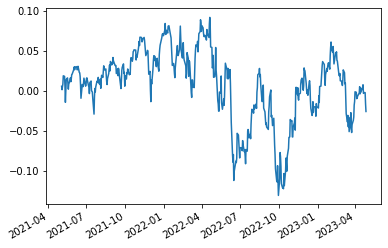

<AxesSubplot:>

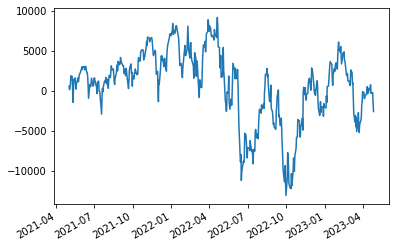

In [18]:
# Get weighted returns & scale based on pct notional exposure
raw_rets = (close_asset_returns.tail(500)*weights).sum(1)*notional_pct_exposure
pt.cumulative_returns(raw_rets).plot()
plt.show()
# Scale returns according to portfolio value of $100k
(portfolio_value*pt.cumulative_returns(raw_rets)).plot()

<AxesSubplot:>

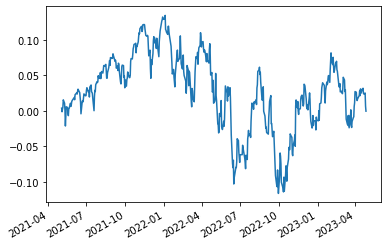

In [20]:
pt.cumulative_returns((close_asset_returns.tail(500) / len(close_asset_returns.columns)).sum(1)).plot()

In [24]:
pt.performance_summary(raw_rets), pt.performance_summary((close_asset_returns.tail(500) / len(close_asset_returns.columns)).sum(1))

(                             Performance Summary
 Sharpe Ratio                               0.018
 Drift Adjusted Sharpe Ratio               -0.170
 CAGR                                      -0.016
 Vol                                        0.182
 Sortino Ratio                              0.027
 Martin (Ulcer) Ratio                       0.041
 Omega Ratio                                0.943
 RR Ratio                                   1.003
 Win Rate                                   0.496
 Skew                                      -0.004
 Kurtosis                                   4.166
 Max Drawdown                              -0.204
 VaR - Laplace                             -0.045
 CVaR - Laplace                            -0.056
 Tail-Risk Density                          0.000,
                              Performance Summary
 Sharpe Ratio                               0.097
 Drift Adjusted Sharpe Ratio               -0.169
 CAGR                                      -0.002